# Predicting Animal Shelter Outcomes v3

A guide to handling categorical variables in supervised machine learning.

The following notebook is taken from https://medium.com/vickdata/predicting-animal-shelter-outcomes-4c5fad5dbb4f
Kudos to Rebecca Vickery for an outstanding example of clever feature engineering.

Dr Jose M Albornoz, May 2019

The data (to be found [here](https://www.kaggle.com/c/shelter-animal-outcomes)) comprises a number of characteristics about animals that were admitted to the Austin Animal Center between 1st October 2013 and March 2016. You are asked to predict the outcome for each animal of which there are 5 possibilities:

* Adoption
* Transfer
* Return to owner
* Euthanasia
* Died

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV

# 1.- Read and inspect data

In [2]:
df_0 = pd.read_csv("train.csv")

In [3]:
df_0.shape

(26729, 10)

In [4]:
df_0.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
df_0.dtypes

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

All variables are categorical with the exception of *AgeuponOutcome*, which is numerical. Let's visualise the proportion of outcome types:

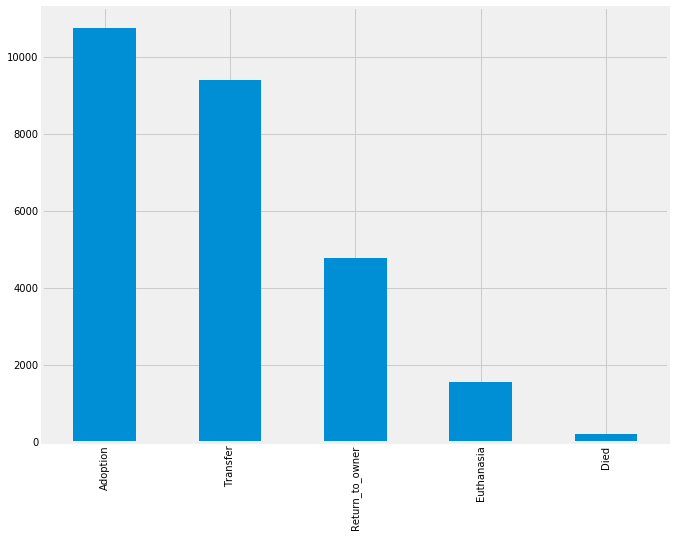

In [6]:
plt.figure(figsize=(10,8))
df_0['OutcomeType'].value_counts().plot.bar()

We will now get a count of unique values in each column and perform an examination of these unique values

In [7]:
columns = df_0.columns
for column in columns:
    print(column + ": " + str(df_0[column].nunique()))

AnimalID: 26729
Name: 6374
DateTime: 22918
OutcomeType: 5
OutcomeSubtype: 16
AnimalType: 2
SexuponOutcome: 5
AgeuponOutcome: 44
Breed: 1380
Color: 366


In [8]:
df_0['OutcomeSubtype'].unique()

array([nan, 'Suffering', 'Foster', 'Partner', 'Offsite', 'SCRP',
       'Aggressive', 'Behavior', 'Rabies Risk', 'Medical', 'In Kennel',
       'In Foster', 'Barn', 'Court/Investigation', 'Enroute', 'At Vet',
       'In Surgery'], dtype=object)

In [9]:
df_0['AnimalType'].unique()

array(['Dog', 'Cat'], dtype=object)

In [10]:
df_0['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [11]:
df_0['Name'].unique()[:10]

array(['Hambone', 'Emily', 'Pearce', nan, 'Elsa', 'Jimmy', 'Lucy',
       'Rocket', 'Scooter', 'Preston'], dtype=object)

In [12]:
df_0['Breed'].unique()[:10]

array(['Shetland Sheepdog Mix', 'Domestic Shorthair Mix', 'Pit Bull Mix',
       'Lhasa Apso/Miniature Poodle', 'Cairn Terrier/Chihuahua Shorthair',
       'American Pit Bull Terrier Mix', 'Cairn Terrier',
       'Miniature Schnauzer Mix', 'Yorkshire Terrier Mix',
       'Great Pyrenees Mix'], dtype=object)

In [13]:
df_0['Color'].unique()[:10]

array(['Brown/White', 'Cream Tabby', 'Blue/White', 'Blue Cream', 'Tan',
       'Black/Tan', 'Blue Tabby', 'Brown Tabby', 'Red/White', 'White'],
      dtype=object)

In [14]:
df_0['AgeuponOutcome'][:10]

0      1 year
1      1 year
2     2 years
3     3 weeks
4     2 years
5     1 month
6     3 weeks
7     3 weeks
8    5 months
9      1 year
Name: AgeuponOutcome, dtype: object

# 2.- Data Preprocessing

In [15]:
df_1 = df_0.copy()

## 2.1.- Missing Values

In [16]:
columns = df_1.columns
for column in columns:
    print(column + ": " + str(df_1[column].isna().sum()))

AnimalID: 0
Name: 7691
DateTime: 0
OutcomeType: 0
OutcomeSubtype: 13612
AnimalType: 0
SexuponOutcome: 1
AgeuponOutcome: 18
Breed: 0
Color: 0


In [17]:
df_1.apply(lambda x: sum(x.isnull()*100/len(df_0)))

AnimalID           0.000000
Name              28.773991
DateTime           0.000000
OutcomeType        0.000000
OutcomeSubtype    50.925961
AnimalType         0.000000
SexuponOutcome     0.003741
AgeuponOutcome     0.067343
Breed              0.000000
Color              0.000000
dtype: float64

Half of the outcome subtypes are absent. Roughly 30% of the animals do not have a name (strays?). We will therefore drop *OutcomeSubtype*, and create a new column for name: *HasName*

In [18]:
df_1.drop("OutcomeSubtype", axis=1, inplace=True)

In [19]:
df_1['Name'] = df_1['Name'].fillna(value=0)
df_1['hasName'] = (df_1['Name'] != 0).astype('int64')
df_1.drop('Name', axis=1, inplace=True)

*SexuponOutcome* and *AgeuponOutcome* have a small proportion of missing values, and therefore these will be replaced by the most common value in each column

In [20]:
df_1 = df_1.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [21]:
df_1.apply(lambda x: sum(x.isnull()*100/len(df_1)))

AnimalID          0.0
DateTime          0.0
OutcomeType       0.0
AnimalType        0.0
SexuponOutcome    0.0
AgeuponOutcome    0.0
Breed             0.0
Color             0.0
hasName           0.0
dtype: float64

Finally, *AnimalID* and *DateTime* are dropped as they do not provide any meaningful information

In [22]:
df_1.drop(['DateTime', 'AnimalID'], axis=1, inplace=True)

## 2.2.- Encoding Categorical Variables

Given that there are only two levels in this variable, one-hot encoding is a good encoding choice.

In [23]:
df_1[['Cat', 'Dog']] = pd.get_dummies(df_1['AnimalType'])

In [24]:
df_1.drop("AnimalType", axis=1, inplace=True)

In [25]:
df_1.head()

,OutcomeType,SexuponOutcome,AgeuponOutcome,Breed,Color,hasName,Cat,Dog
0,Return_to_owner,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,0,1
1,Euthanasia,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,1,0
2,Adoption,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,0,1
3,Transfer,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0,1,0
4,Transfer,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,0,1


There are two features with very high cardinality: *Breed* and *Color*. In this first version of the notebook we will reduce the cardinality of these features by creating meaningful categorisation of the values

### 2.2.1.- Color

In [26]:
df_1['multi_colors'] = df_1['Color'].apply(lambda x : 'Multicolor' if '/' in x else x)

In [27]:
df_1['multi_colors'].nunique()

55

### 2.2.2.- Breed

In [28]:
df_1['breed_type'] = df_1.Breed.str.extract('({})'.format('|'.join(['Mix'])),  
                                             flags=re.IGNORECASE, expand=False).str.lower().fillna('pure')

In [29]:
df_1['breed_type'].nunique()

2

### 2.2.3.- One-hot encoding of *multi_colors* and *breed_type*

In [30]:
df_1 = pd.get_dummies(df_1, prefix_sep="_", columns=['multi_colors', 'breed_type'])

In [31]:
df_1.drop(['Color', 'Breed'], axis=1, inplace=True)

### 2.2.3.- Other features

In [32]:
le = LabelEncoder()

In [33]:
df_1['SexuponOutcome_encoded'] = le.fit_transform(df_1['SexuponOutcome'])

In [34]:
df_1.drop('SexuponOutcome', axis=1, inplace=True)

In [35]:
df_1['Label'] = le.fit_transform(df_1['OutcomeType'])

In [36]:
df_1.drop('OutcomeType', axis=1, inplace=True)

*AgeuponOutcome* is a string-based variable that will be converted in age in days using the below function from the Kaggle kernel:

In [37]:
def age_converter(row):
    age_string = row['AgeuponOutcome']
    [age,unit] = age_string.split(" ")
    unit = unit.lower()
    if("day" in unit):
        if age=='0': return 1
        return int(age)
    if("week" in unit):
        if(age)=='0': return 7
        return int(age)*7
    elif("month" in unit):
        if(age)=='0': return 30
        return int(age) * 4*7
    elif("year" in unit):
        if(age)=='0': return 365
        return int(age) * 4*12*7

In [38]:
df_1['age_numeric'] = df_1.apply(age_converter, axis=1)

In [39]:
df_1.drop('AgeuponOutcome', axis=1, inplace=True)

In [41]:
df_1.shape

(26729, 63)

# 3.- Model Training

## 3.1.- Train-Test Split

In [42]:
X = df_1.drop('Label', axis=1)
y = df_1['Label']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

## 3.2.- Grid Search

In [44]:
n_trees = [100, 150, 200, 250]
max_depth = [5, 10, 15, 20, 25, 30]
min_samples_leaf = [10, 15, 20, 25, 30, 35, 40, 45, 50]
param_grid = [{'n_estimators': n_trees, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}]

In [45]:
rf = RandomForestClassifier()
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [46]:
gs = gs.fit(X_train, y_train)

In [47]:
print(gs.best_score_)

0.6397648316408338


In [48]:
print(gs.best_params_)

{'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 150}


In [49]:
clf = gs.best_estimator_

## 3.3.- Performance on test set

In [50]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.6391071205886021


Nice - no overfitting

In [51]:
y_prob = clf.predict_proba(X_test)
print(log_loss(y_test, y_prob))

0.9103335168835853


## 3.4.- Feature Importances

In [52]:
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

<function matplotlib.pyplot.show(*args, **kw)>

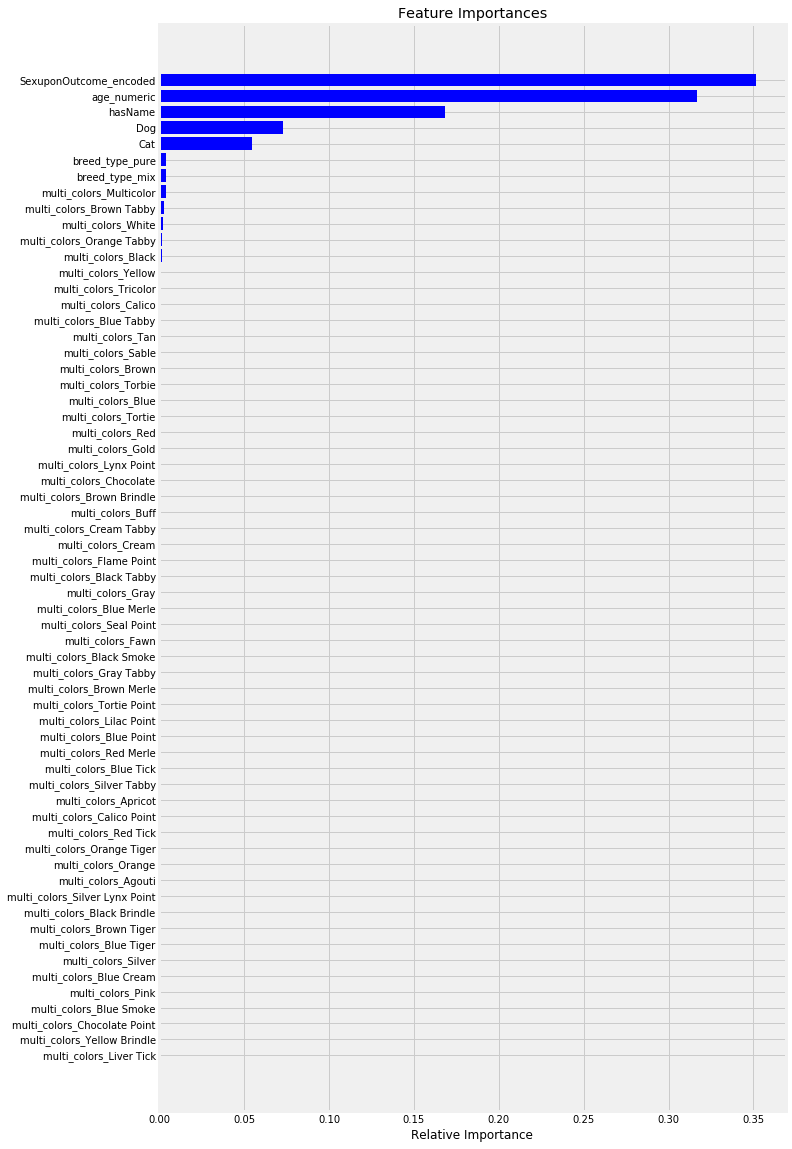

In [53]:
plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show